In [1]:
from protos import scenario_pb2
from tensorflow.data import TFRecordDataset

2023-08-08 21:13:07.968769: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 21:13:08.112658: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 21:13:08.113511: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 21:13:09.366503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os

def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]

files = getFiles('~/data/waymo/')

In [16]:
import tqdm
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    heading: float
    velocity: np.ndarray


def parse_scenario(scenario: scenario_pb2.Scenario) -> list[State]:
    states = []
    for s in scenario.tracks[scenario.sdc_track_index].states:
        if s.valid:
            heading = np.arctan2(s.velocity_y, s.velocity_x)
            states.append(State(heading, np.array([s.velocity_x, s.velocity_y], dtype=np.float32)))
    return states


h: list[list[State]] = []

for file_path in tqdm.tqdm(files):
    for data in TFRecordDataset(file_path, compression_type="").as_numpy_iterator():
        scenario = scenario_pb2.Scenario()
        scenario.ParseFromString(data)
        h.append(parse_scenario(scenario))


 12%|█▏        | 12/100 [07:53<57:54, 39.49s/it]  


KeyboardInterrupt: 

In [202]:
print("trajectories: ", len(h))
if len(h) > 0:
    lens = [len(x) for x in h]
    print("avg len: ", sum(lens)/len(lens))

trajectories:  6949
avg len:  198.46064181896676


In [12]:
def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

for s in h[4]:
    err = normalize_angle(np.arctan2(s.velocity[1], s.velocity[0])- s.heading)**2
    print(s.velocity[0], s.velocity[1])
    print(np.arctan2(s.velocity[1], s.velocity[0]), s.heading)

-0.6033403 -0.29557413
-2.6860607 -2.685227394104004
-0.63066554 -0.31144542
-2.6828883 -2.6853933334350586
-0.6925942 -0.3451719
-2.6792455 -2.6853065490722656
-0.75051224 -0.36821628
-2.6854773 -2.685509204864502
-0.80487454 -0.39107856
-2.6892986 -2.6857566833496094
-0.8647316 -0.42277873
-2.6868536 -2.685789108276367
-0.9241577 -0.45644513
-2.6828337 -2.685671091079712
-0.9855256 -0.4867216
-2.682861 -2.6856818199157715
-1.0384393 -0.5009156
-2.6921453 -2.6858057975769043
-1.0500392 -0.5094217
-2.6898992 -2.685610055923462
-1.0415444 -0.51445305
-2.6828105 -2.6852898597717285
-1.0481974 -0.5140947
-2.6856093 -2.685591697692871
-1.0570596 -0.5136322
-2.6892834 -2.6861698627471924
-1.0585835 -0.51602805
-2.6880188 -2.6862194538116455
-1.0543981 -0.5163588
-2.6862035 -2.6857070922851562
-1.0561582 -0.5174523
-2.6860268 -2.6856772899627686
-1.057772 -0.5175353
-2.6865664 -2.6860313415527344
-1.0525867 -0.5155731
-2.686126 -2.686190605163574
-1.0435711 -0.5168889
-2.681706 -2.6860704421

In [307]:
import random
# convert into a dataset of tuples (state, next_state)
dataset = []
for states in h:
    for i in range(len(states)-1):
        if np.linalg.norm(states[i].velocity) > 0.1:
            dataset.append((states[i], states[i+1]))

# shuffle the dataset
random.shuffle(dataset)

In [26]:
dataset = [(h[0][0], h[0][1])] * 10000

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create an idm that attempts to predict: throttle and steering
# given state at current timestep, and state at next timestep:
# each state contains: velocity_x, velocity_y, and heading
class IDM(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 6, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(3, 512, 2) # Bx3x2 -> Bx512x1
        self.fc1 = nn.Linear(512, 256) # Bx512 -> Bx256
        self.fc2 = nn.Linear(256, 256) # Bx256 -> Bx256
        self.fc3 = nn.Linear(256, 2) # Bx256 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx3x2 -> Bx512x1
        x = torch.flatten(x, 1) # Bx512x1 -> Bx512
        x = F.relu(self.fc1(x)) # Bx512 -> Bx256
        x = F.relu(self.fc2(x)) # Bx256 -> Bx256
        x = self.fc3(x) # Bx256 -> Bx2
        return x


# How to train the Inverse Dynamics Model

An IDM (Inverse Dynamics Model) is a model that predicts the control input (steering angle and acceleration) given the current state of the vehicle and the next state of the vehicle. In RL parlance, we have $s_t$ and $s_{t+1}$ and we want to predict $a_t$.

We're training the IDM on the Waymo Motion Dataset. The dataset contains several thousand trajectories of vehicles driving in a variety of environments. The trajectories are sampled at 10Hz, and each sample contains the state of the vehicle (position, velocity, heading, etc.) and the environment (traffic lights, other vehicles, etc.). However, it does not contain the control input (steering angle and acceleration) of the vehicle. This is what we want to predict.

To do this, we'll leverage the Metadrive simulator. We reformulate the problem of predicting the action as a RL game where the model tries to take the action that will result in the next state in the simulator being as close as possible to the ground truth next state. The reward function is the negative of the distance between the predicted next state and the ground truth next state. We train the model using PPO. 

In [18]:
import metadrive
import gymnasium as gym
import typing

Observation: typing.TypeAlias = tuple[State, State]

def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return vel_error + heading_error

def get_metadrive_state(env: gym.Env) -> State:
    return State(heading=env.vehicle.heading_theta, velocity=env.vehicle.velocity[:2])

def run_game(env:gym.Env, policy:typing.Callable[[Observation], tuple[float, float]], o: Observation) -> tuple[tuple[float, float], float, State]:
    """
    runs the policy and returns the total reward
    """
    st0, st1 = o
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(st0.velocity)
    env.vehicle.set_heading_theta(st0.heading)
    
    # run the policy
    action = policy(o)
    env.step(action)

    # compute the reward
    st1_pred = get_metadrive_state(env)
    reward = -compute_loss(st1_pred, st1)

    # allow car to settle (if rendering)
    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return action, reward, st1_pred

def obs_batch_to_tensor(obs: list[Observation], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 3, 2)
    """

    observations = []

    for st0, st1 in obs:
        observations.append(np.array([
            [st0.velocity[0], st1.velocity[0]], 
            [st0.velocity[1], st1.velocity[1]],
            [st0.heading, st1.heading]
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)


def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

In [20]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.idm = IDM()

    def forward(self, x: torch.Tensor) -> torch.distributions.MultivariateNormal:
        mu = self.idm(x)
        # sigma is fixed at 0.05
        sigma = 0.1*torch.ones_like(mu)
        return torch.distributions.MultivariateNormal(mu, torch.diag_embed(sigma))

class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 6, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(3, 512, 2) # Bx3x2 -> Bx512x1
        self.fc1 = nn.Linear(512, 256) # Bx512 -> Bx256
        self.fc2 = nn.Linear(256, 256) # Bx256 -> Bx256
        self.fc3 = nn.Linear(256, 1) # Bx256 -> Bx1
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx3x2 -> Bx512x1
        x = torch.flatten(x, 1) # Bx512x1 -> Bx512
        x = F.relu(self.fc1(x)) # Bx512 -> Bx256
        x = F.relu(self.fc2(x)) # Bx256 -> Bx256
        x = self.fc3(x) # Bx256 -> Bx1

        output = torch.squeeze(x, dim=1) # Bx1 -> B
        return output

class ActorPolicy:
    def __init__(self, net: Actor):
        self.net = net

    def __call__(self, o:Observation) -> tuple[float, float]:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([o], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            throttle, steering = self.net(obs_tensor).sample()[0]
            
        return throttle.item(), steering.item()

class IDMPolicy:
    def __init__(self, net: IDM):
        self.net = net

    def __call__(self, o:Observation) -> tuple[float, float]:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([o], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            throttle, steering = self.net(obs_tensor)[0]
        #return throttle.item(), steering.item()
        return steering.item(), throttle.item()

def compute_advantage(critic:Critic, o: Observation, reward: float) -> float:
    with torch.no_grad():
        return float(reward - critic(obs_batch_to_tensor([o], deviceof(critic)))[0])

@dataclass
class PPOConfig:
    ppo_eps: float
    ppo_grad_descent_steps: int

def compute_ppo_loss(
    # Old policy network's distribution of actions given a state
    # inner shape = (Batch, 2)
    pi_thetak_given_st: torch.distributions.MultivariateNormal,
    # Current policy network's distribution of actions given a state
    # in (Batch, Action)
    pi_theta_given_st: torch.distributions.MultivariateNormal,
    # The action chosen by the old policy network
    # in (Batch, 2)
    a_t: torch.Tensor,
    # Advantage of the chosen action
    # in (Batch,)
    A_pi_thetak_given_st_at: torch.Tensor,
    # configuration options
    config: PPOConfig
) -> torch.Tensor:
    # the likelihood ratio (used to penalize divergence from the old policy)
    # in (Batch,)
    likelihood_ratio = torch.exp(pi_theta_given_st.log_prob(a_t) - pi_thetak_given_st.log_prob(a_t))

    # in (Batch,)
    ppo_loss_per_example = -torch.minimum(
        likelihood_ratio * A_pi_thetak_given_st_at,
        torch.clip(likelihood_ratio, 1 - config.ppo_eps, 1 + config.ppo_eps) * A_pi_thetak_given_st_at,
    )

    loss_per_example = ppo_loss_per_example

    # we take the average loss over all examples
    return loss_per_example.mean()

def train_ppo(
    actor: Actor,
    critic: Critic,
    actor_optimizer: torch.optim.Optimizer,
    critic_optimizer: torch.optim.Optimizer,
    observation_batch: list[Observation],
    action_batch: list[tuple[float, float]],
    advantage_batch: list[float],
    reward_to_go_batch: list[float],
    config: PPOConfig
) -> tuple[list[float], list[float]]:
    # assert that the models are on the same device
    assert deviceof(critic) == deviceof(actor)
    # assert that the batch_lengths are the same
    assert len(observation_batch) == len(action_batch)
    assert len(observation_batch) == len(advantage_batch)
    assert len(observation_batch) == len(reward_to_go_batch)

    # get device
    device = deviceof(critic)

    # convert data to tensors on correct device

    # in (Batch, Width, Height)
    observation_batch_tensor = obs_batch_to_tensor(observation_batch, device)

    # the true V^pi(s) is reward to go
    # in (Batch,)
    true_value_batch_tensor = torch.tensor(
        reward_to_go_batch, dtype=torch.float32, device=device
    )

    # in (Batch, 2)
    chosen_action_tensor = torch.tensor(action_batch, device=device)

    # in (Batch,)
    advantage_batch_tensor = torch.tensor(advantage_batch, device=device)

    # train critic
    critic_optimizer.zero_grad()
    pred_value_batch_tensor = critic.forward(observation_batch_tensor)
    critic_loss = F.mse_loss(pred_value_batch_tensor, true_value_batch_tensor)
    critic_loss.backward()
    critic_optimizer.step()

    # train actor

    # Recall that in the PPO algorithm, we need to set theta to the *optimal* theta with respect to the surrogate loss function,
    # as opposed to the standard policy gradient, where we just update theta.

    # Here's what that means:
    # We have a policy network with parameters theta_k
    # We want to find the optimal theta, theta*, that maximizes the surrogate loss function L_CLIP(theta, theta_k)
    # Note: In practice, we just use gradient descent for PPO_GRAD_DESCENT_STEPS steps to approximate theta*, since we can't analytically solve for theta*
    # We then update: theta_k <- theta*

    # The amount theta* can diverge from theta_k is limited by L_CLIP(theta, theta_k).
    # This is because we want to avoid the new policy diverging too far from the old policy, since that can lead to instability.

    # the old_policy_action_probs are the the predictions made by the pre-train-step network that we want to not diverge too far away from
    # in (Batch, Action)
    with torch.no_grad():
        old_policy_action_probs = actor.forward(observation_batch_tensor)

    actor_losses = []
    for _ in range(config.ppo_grad_descent_steps):
        actor_optimizer.zero_grad()
        current_policy_action_probs = actor.forward(observation_batch_tensor)
        actor_loss = compute_ppo_loss(
            old_policy_action_probs,
            current_policy_action_probs,
            chosen_action_tensor,
            advantage_batch_tensor,
            config
        )
        actor_loss.backward()
        actor_optimizer.step()
        actor_losses.append(float(actor_loss))


    # return the respective losses
    return actor_losses, [float(critic_loss)]*config.ppo_grad_descent_steps

In [22]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

actor = Actor().to(device)
critic = Critic().to(device)

actor_optimizer = torch.optim.Adam(actor.parameters())
critic_optimizer = torch.optim.Adam(critic.parameters())

dataset_iterator = iter(dataset)

step = 0
returns = []
actor_losses = []
critic_losses = []

In [9]:
# disable logging from metadrive
import logging
import inspect
import metadrive.envs.base_env
logging.getLogger(inspect.getfile(metadrive.envs.base_env)).setLevel(logging.WARNING)

In [10]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": False})

In [23]:
set_lr(actor_optimizer, 1e-5)
CONFIG = PPOConfig(
    ppo_eps=0.1,
    ppo_grad_descent_steps=10,
)
# the critic has to learn faster than the actor
set_lr(critic_optimizer, 3e-3)

TRAIN_EPOCHS = 200
EPISODES_PER_BATCH = 256

# Train
while step < TRAIN_EPOCHS:
    obs_batch:list[tuple[State, State]] = []
    act_batch:list[tuple[float, float]] = []
    rtg_batch:list[float] = []
    adv_batch:list[float] = []
    
    trajectory_returns = []

    for _ in range(EPISODES_PER_BATCH):
        o = next(dataset_iterator)
        # Collect trajectory
        action, reward, st1_pred = run_game(env, ActorPolicy(actor), o)

        # Update batch
        obs_batch.append(o)
        act_batch.append(action)
        rtg_batch.append(reward)
        adv_batch.append(compute_advantage(critic, o, reward))

        # Update trajectory returns
        trajectory_returns.append(reward)

        # print(action)
        # print(o[1], st1_pred)

        #if reward < -2:
        #    raise ValueError("oof")

    batch_actor_losses, batch_critic_losses = train_ppo(
        actor,
        critic,
        actor_optimizer,
        critic_optimizer,
        obs_batch,
        act_batch,
        adv_batch,
        rtg_batch,
        CONFIG,
    )

    # collect statistics
    returns.append(trajectory_returns)
    actor_losses.extend(batch_actor_losses)
    critic_losses.extend(batch_critic_losses)

    print(f"Step {step}, Avg. Returns: {np.mean(trajectory_returns):.3f} +/- {np.std(trajectory_returns):.3f}, Median: {np.median(trajectory_returns):.3f}, Actor Loss: {actor_losses[-1]:.3f}, Critic Loss: {batch_critic_losses[-1]:.3f}")

    step += 1

Step 0, Avg. Returns: -0.221 +/- 0.142, Median: -0.219, Actor Loss: -0.048, Critic Loss: 0.022
Step 1, Avg. Returns: -0.212 +/- 0.134, Median: -0.221, Actor Loss: 2.768, Critic Loss: 7.801
Step 2, Avg. Returns: -0.203 +/- 0.106, Median: -0.218, Actor Loss: 0.694, Critic Loss: 0.492
Step 3, Avg. Returns: -0.212 +/- 0.116, Median: -0.217, Actor Loss: -0.343, Critic Loss: 0.130
Step 4, Avg. Returns: -0.195 +/- 0.103, Median: -0.221, Actor Loss: -0.509, Critic Loss: 0.267
Step 5, Avg. Returns: -0.204 +/- 0.094, Median: -0.219, Actor Loss: -0.282, Critic Loss: 0.088
Step 6, Avg. Returns: -0.200 +/- 0.119, Median: -0.217, Actor Loss: 0.036, Critic Loss: 0.016
Step 7, Avg. Returns: -0.194 +/- 0.095, Median: -0.215, Actor Loss: 0.251, Critic Loss: 0.072
Step 8, Avg. Returns: -0.201 +/- 0.111, Median: -0.218, Actor Loss: 0.277, Critic Loss: 0.089
Step 9, Avg. Returns: -0.195 +/- 0.087, Median: -0.218, Actor Loss: 0.163, Critic Loss: 0.034
Step 10, Avg. Returns: -0.191 +/- 0.091, Median: -0.211,

StopIteration: 

In [27]:
dataset

[(State(heading=-0.10642205771463185, velocity=array([ 8.535741 , -0.9118361], dtype=float32)),
  State(heading=-0.10621603897725837, velocity=array([ 8.434904 , -0.8993066], dtype=float32))),
 (State(heading=-0.10642205771463185, velocity=array([ 8.535741 , -0.9118361], dtype=float32)),
  State(heading=-0.10621603897725837, velocity=array([ 8.434904 , -0.8993066], dtype=float32))),
 (State(heading=-0.10642205771463185, velocity=array([ 8.535741 , -0.9118361], dtype=float32)),
  State(heading=-0.10621603897725837, velocity=array([ 8.434904 , -0.8993066], dtype=float32))),
 (State(heading=-0.10642205771463185, velocity=array([ 8.535741 , -0.9118361], dtype=float32)),
  State(heading=-0.10621603897725837, velocity=array([ 8.434904 , -0.8993066], dtype=float32))),
 (State(heading=-0.10642205771463185, velocity=array([ 8.535741 , -0.9118361], dtype=float32)),
  State(heading=-0.10621603897725837, velocity=array([ 8.434904 , -0.8993066], dtype=float32))),
 (State(heading=-0.1064220577146318

In [328]:
env.close()

Let's try visualizing our IDM by having it follow a scenario from start to finish.

In [329]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

In [330]:
scenario = h[0]
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        action = ActorPolicy(actor)((st0, st1))
        print("a", normalize_angle(st1.heading - st0.heading))
        print(action)
        env.step(action)
        print(compute_loss(get_metadrive_state(env), st1))
        

Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


a -0.0012819692492485046
(2.181495428085327, 2.6553831100463867)
0.15700651464859458
a -0.0014934465289115906
(2.6770126819610596, 2.904482364654541)
0.6889131823664087
a -0.0013835728168487549
(2.194956064224243, 0.6304646730422974)
1.793419167757034
a -0.0011183544993400574
(2.299562931060791, 2.1594114303588867)
3.4709756896106057
a -0.0012847930192947388
(2.4715800285339355, 1.1299500465393066)
5.739751013235498
a -0.0009468644857406616
(3.2626733779907227, 1.9276268482208252)
8.656036741286599
a -0.0002813264727592468
(1.4301648139953613, 1.2959415912628174)
12.127296984495285
a -4.682689905166626e-05
(2.1598708629608154, 1.2518495321273804)
16.144684034361013
a -0.00025801360607147217
(2.247896194458008, 1.4120105504989624)
20.65081856114586
a -0.00040455162525177
(2.4177281856536865, 1.9678879976272583)
25.59547895407066
a -0.0004618316888809204
(2.1646711826324463, 0.7283341884613037)
30.763252391924908
a -0.00019865483045578003
(1.9161936044692993, 1.7183066606521606)
36.45963

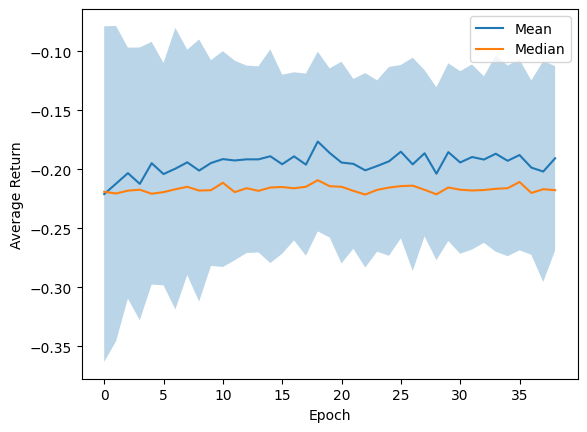

In [24]:
import matplotlib.pyplot as plt
return_medians = [np.median(returns[i]) for i in range(len(returns))]
return_means = [np.mean(returns[i]) for i in range(len(returns))]
return_stds = [np.std(returns[i]) for i in range(len(returns))]
plt.plot(return_means, label="Mean")
plt.plot(return_medians, label="Median")
plt.fill_between(range(len(return_means)), np.array(return_means) - np.array(return_stds), np.array(return_means) + np.array(return_stds), alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Average Return")
plt.legend()
plt.show()

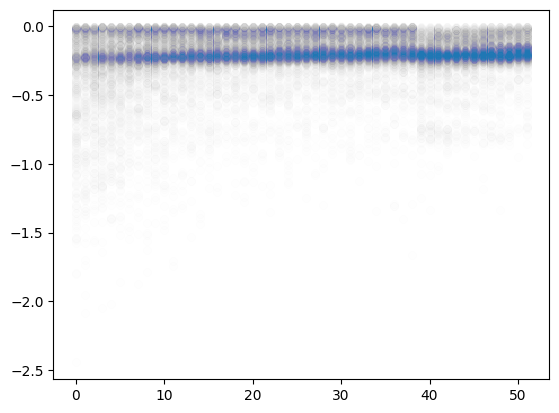

In [311]:
# scatter plot of the returns
xs = []
ys = []
for t, rets in enumerate(returns):
    for ret in rets:
        xs.append(t)
        ys.append(ret)
plt.scatter(xs, ys, alpha=0.003)

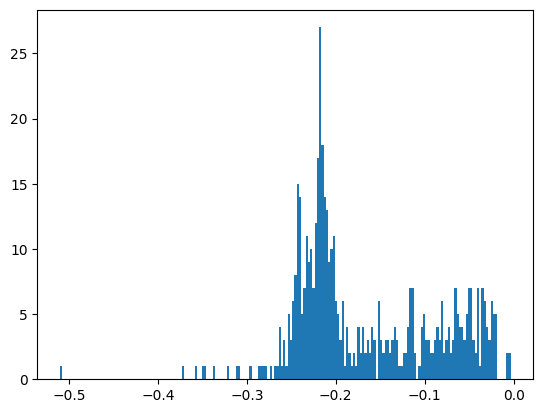

In [15]:
returns_no_outlier = [r for r in returns[-1]]
plt.hist(returns_no_outlier, bins=200)
plt.show()

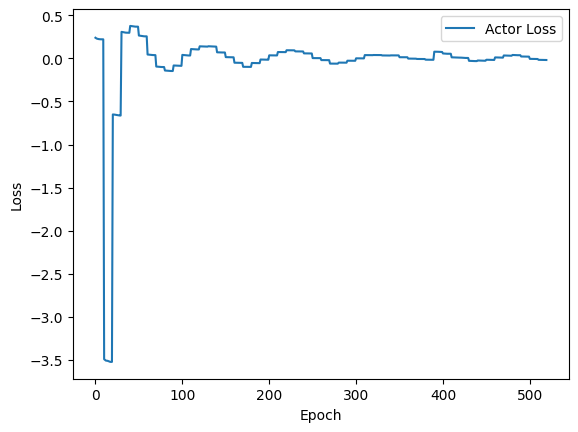

In [313]:
# plot actor losses
plt.plot(actor_losses[:], label="Actor Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

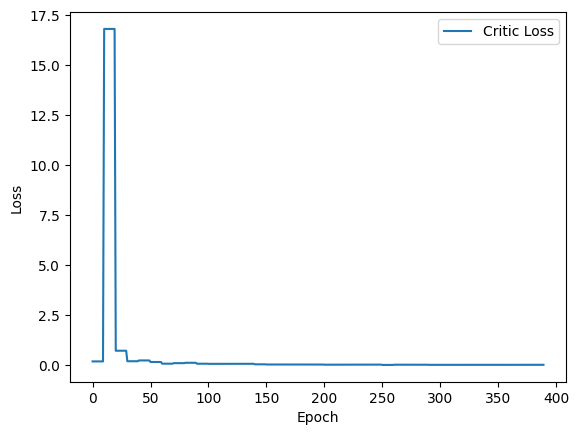

In [305]:
# plot critic losses
plt.plot(critic_losses, label="Critic Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

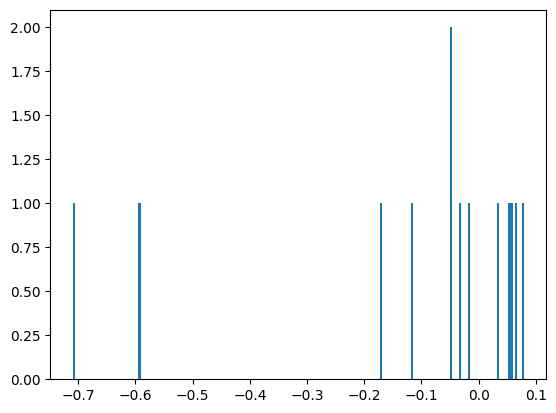

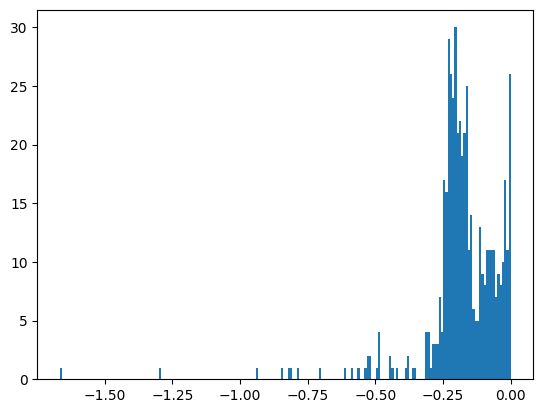

In [306]:
plt.hist([float(a) for a in adv_batch], bins=200)
plt.show()
plt.hist(returns[-1], bins=200)
plt.show()

In [240]:
st0, st1 = o
print(st0)
print(st1)
print(st1_pred)
print(action)
print(adv_batch[-1])
print(reward)


State(heading=-1.5578415393829346, velocity=array([  0.18206005, -18.881638  ], dtype=float32))
State(heading=-1.5574579238891602, velocity=array([  0.17337647, -17.022293  ], dtype=float32))
State(heading=-1.553571799812591, velocity=array([  0.59126008, -18.69710541]))
(1.2610465288162231, 2.244649887084961)
-2.720515251159668
-2.9796381059133052


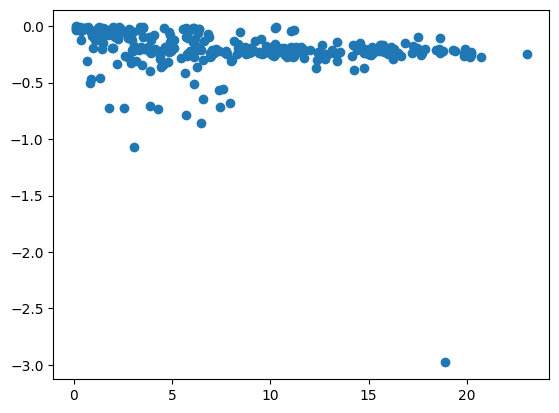

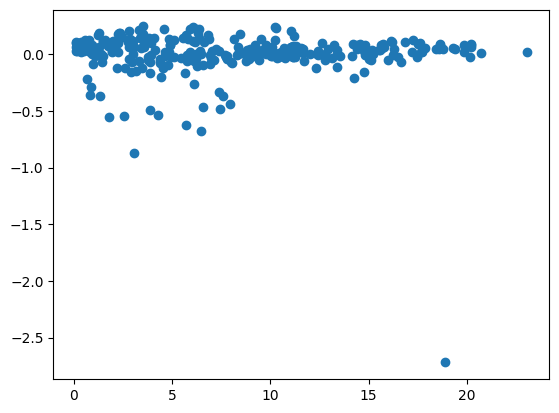

In [241]:
speeds = [np.linalg.norm(s0.velocity) for s0, _ in obs_batch]
plt.scatter(speeds, rtg_batch)
plt.show()
plt.scatter(speeds, adv_batch)

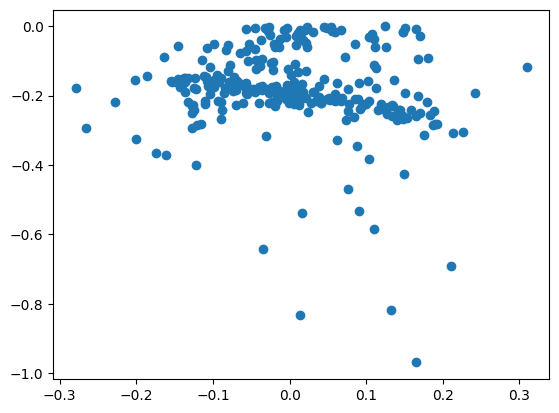

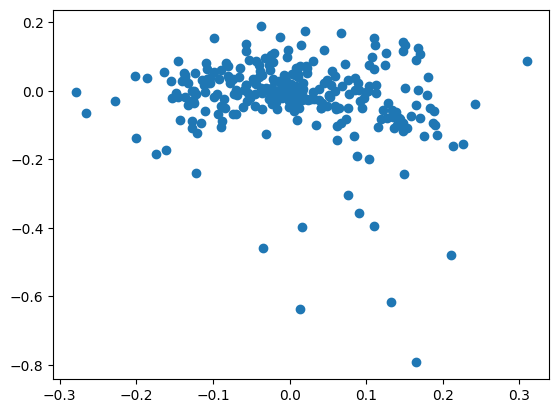

In [268]:
accelerations = [np.linalg.norm(s1.velocity) - np.linalg.norm(s0.velocity) for s0, s1 in obs_batch]
plt.scatter(accelerations, rtg_batch)
plt.show()
plt.scatter(accelerations, adv_batch)

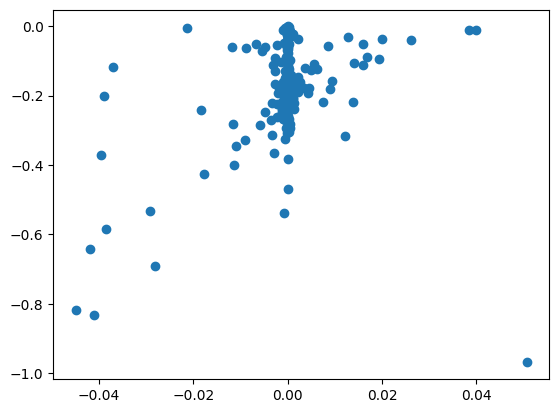

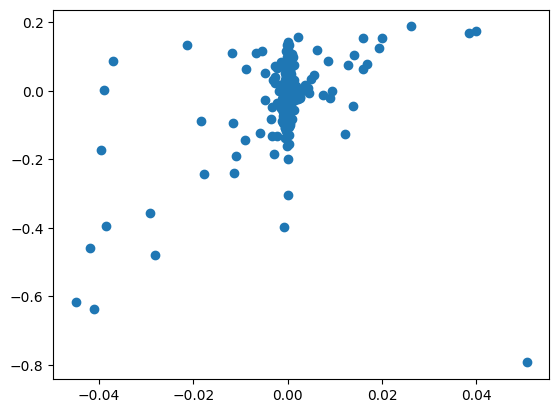

In [270]:
ang_accels = [normalize_angle(s1.heading - s0.heading) for s0, s1 in obs_batch]
plt.scatter(ang_accels, rtg_batch)
plt.show()
plt.scatter(ang_accels, adv_batch)